In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from nltk.corpus import stopwords
from wordcloud import WordCloud
from nltk import word_tokenize, sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.stem import WordNetLemmatizer 
import string
import re
import nltk
import datetime as dt
from PIL import Image


Bad key "text.kerning_factor" on line 4 in
C:\Users\HP\AppData\Local\Continuum\anaconda3\envs\eods-f21\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.2/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
import seaborn as sns
sns.set_style("darkgrid")

In [3]:
company_names = pd.read_csv('C:\\Users\\HP\\Desktop\\columbia\\applied machine learning\\group project\\Company.csv')
company_tweet = pd.read_csv('C:\\Users\\HP\\Desktop\\columbia\\applied machine learning\\group project\\archive\\Company_Tweet.csv')
company_values = pd.read_csv('C:\\Users\\HP\\Desktop\\columbia\\applied machine learning\\group project\\CompanyValues.csv')
tweet  = pd.read_csv('C:\\Users\\HP\\Desktop\\columbia\\applied machine learning\\group project\\archive\\Tweet.csv')
DJIA_prices = pd.read_csv('C:\\Users\\HP\\Desktop\\columbia\\applied machine learning\\group project\\upload_DJIA_table.csv')
news = pd.read_csv('C:\\Users\\HP\\Desktop\\columbia\\applied machine learning\\group project\\Combined_News_DJIA.csv')


# prices = pd.read_csv('C:\\Users\\HP\\Desktop\\columbia\\applied machine learning\\group project\\upload_DJIA_table.csv')
# news = pd.read_csv('C:\\Users\\HP\\Desktop\\columbia\\applied machine learning\\group project\\Combined_News_DJIA.csv')

In [35]:
def remove_Stopwords(text):
    stop_words = set(stopwords.words('english')+['appl','aapl','msft','goog','googl','amzn','tsla','stock','market','fb','apple'])
    words = word_tokenize(text.lower())
    sentence = [w for w in words if not w in stop_words and w[:4]!='http']
    return " ".join(sentence)

In [5]:
def lemmatize_text(text):
    wordlist=[]
    lemmatizer = WordNetLemmatizer() 
    sentences=sent_tokenize(text)
    for sentence in sentences:
        words=word_tokenize(sentence)
        for word in words:
            wordlist.append(lemmatizer.lemmatize(word))
    return ' '.join(wordlist) 

In [6]:
def clean_text(text): 
    delete_dict = {sp_character: '' for sp_character in string.punctuation} 
    delete_dict[' '] = ' ' 
    table = str.maketrans(delete_dict)
    text1 = text.translate(table)
    textArr= text1.split()
    text2 = ' '.join([w for w in textArr]) 
    return text2.lower()

In [7]:
cols = news.columns
news_c = news.copy()
news_c['body'] = news['Top1']
for col in cols[3:]:
    news_c['body'] += " " + news[col]

In [8]:
news_c['body'] = news_c['body'].str.split("b'|'|b\"",expand = False)

In [9]:
news_c = news_c.dropna(axis = 0)

In [10]:
for idex,row in news_c.iterrows():
    t = []
    for i in row['body']:
        if i == "":
            continue
        x = remove_Stopwords(i)
        x = lemmatize_text(x)       
        x = clean_text(x)
        t += x.split(' ')
    t = [s for s in t if s!=""]
    news_c['body'][idex] = " ".join(t)
# news_c[0]

C:\Users\HP\AppData\Local\Temp/ipykernel_16128/3725078062.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_c['body'][idex] = " ".join(t)


In [11]:
news_c.to_csv("new_news.csv")

In [12]:
used = DJIA_prices[(DJIA_prices.Date>="2015-01-01") & (DJIA_prices.Date<="2016-12-31")]

In [13]:
news_used = news_c[(news_c.Date>="2015-01-01") & (news_c.Date<="2016-12-31")]

In [14]:
used.index = used.Date
used = used.sort_index()

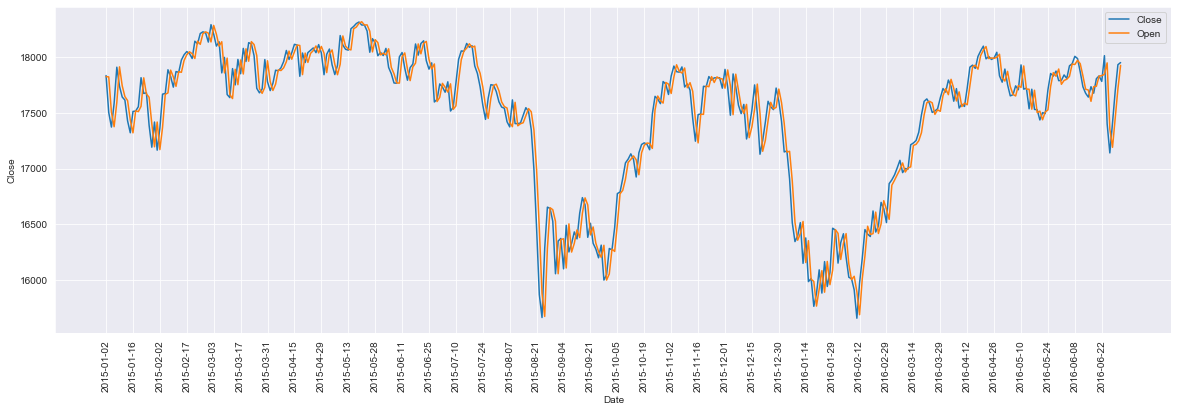

In [15]:
fig,ax = plt.subplots(figsize = (20,6))
sns.lineplot(x = used.index,y = used.Close,ax = ax,label='Close')
sns.lineplot(x = used.index,y = used.Open,ax = ax,label='Open')
ax.set_xticks(range(0,378,10)) 
ax.set_xticklabels(used.index[::10])
plt.xticks(rotation = 90);

C:\Users\HP\AppData\Local\Continuum\anaconda3\envs\eods-f21\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


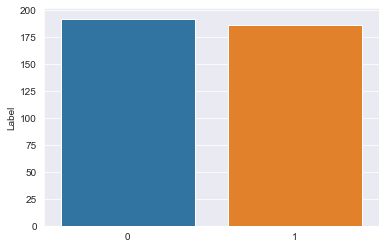

In [16]:

x = [0,1]
y = news_used.Label.value_counts()
sns.barplot(x,y);

In [17]:
#Helper function
def check_freq(x):
    freq = {}
    for c in set(x):
        freq[c] = x.count(c)
    return freq


In [18]:
merged_tweet = company_tweet.merge(tweet, how = 'inner', on = ['tweet_id'])
merged_tweet.post_date = pd.to_datetime(merged_tweet['post_date'], unit='s')

# news['Date'].apply(lambda x: x.strftime('%Y-%m-%d'))
# DJIA_prices['Date'].apply(lambda x: x.strftime('%Y-%m-%d'))

merged_tweet['Date']=merged_tweet['post_date'].apply(lambda x: x.date().strftime('%Y-%m-%d'))
merged_tweet.rename(columns={"post_date":"Datetime"}, inplace=True)

news['Datetime'] = pd.to_datetime(news['Date'])
DJIA_prices['Datetime'] = pd.to_datetime(DJIA_prices['Date'])
company_values.day_date= pd.to_datetime(company_values['day_date'])

date_string="Date"
date_datetime="Datetime"



In [19]:
company_values.day_date= pd.to_datetime(company_values['day_date']).dt.strftime('%Y-%m-%d')

In [20]:
# company_label_dict is a dict for each company and kv of date:label
# print(company_values.columns)
company_values_date_dict=company_values.groupby('ticker_symbol')[['close_value','day_date']].apply(lambda g: g.values.tolist()).to_dict()
company_label_dict={}
for key in company_values_date_dict:
    list1=np.array(company_values_date_dict[key])[:-1,0].astype(float)
    list2=np.array(company_values_date_dict[key])[1:,0].astype(float)
    lb=np.where(list2-list1>0,1,0)
    date=np.array(company_values_date_dict[key])[:-1,1]
    company_label_dict[key]= dict(map(lambda x: (x[0], x[1]),zip(date,lb)))


print(f"company_label_dict: {company_label_dict}")
company_label_pd=pd.DataFrame.from_dict(company_label_dict)




company_label_dict: {'AAPL': {'2020-05-29': 1, '2020-05-28': 0, '2020-05-27': 0, '2020-05-26': 1, '2020-05-22': 0, '2020-05-21': 1, '2020-05-20': 0, '2020-05-19': 1, '2020-05-18': 0, '2020-05-15': 1, '2020-05-14': 0, '2020-05-13': 1, '2020-05-12': 1, '2020-05-11': 0, '2020-05-08': 0, '2020-05-07': 0, '2020-05-06': 0, '2020-05-05': 0, '2020-05-04': 0, '2020-05-01': 1, '2020-04-30': 0, '2020-04-29': 0, '2020-04-28': 1, '2020-04-27': 0, '2020-04-24': 0, '2020-04-23': 1, '2020-04-22': 0, '2020-04-21': 1, '2020-04-20': 1, '2020-04-17': 1, '2020-04-16': 0, '2020-04-15': 1, '2020-04-14': 0, '2020-04-13': 0, '2020-04-09': 0, '2020-04-08': 0, '2020-04-07': 1, '2020-04-06': 0, '2020-04-03': 1, '2020-04-02': 0, '2020-04-01': 1, '2020-03-31': 1, '2020-03-30': 0, '2020-03-27': 1, '2020-03-26': 0, '2020-03-25': 1, '2020-03-24': 0, '2020-03-23': 1, '2020-03-20': 1, '2020-03-19': 1, '2020-03-18': 1, '2020-03-17': 0, '2020-03-16': 1, '2020-03-13': 0, '2020-03-12': 1, '2020-03-11': 1, '2020-03-10': 0, '

In [21]:
dev_split_rate=0.8
train_split_rate=0.8
window_length=30
forward_predict_length=7
start_date=dt.datetime(2015, 1, 1)
end_date=dt.datetime(2015, 4, 11)

start_date_str=start_date.strftime('%Y-%m-%d')
end_date_str=end_date.strftime('%Y-%m-%d')

company_avai_dates=set(company_label_dict['AAPL'].keys())
company_avai_dates_in_range=[date for date in company_avai_dates if (date >=start_date_str) and  (date < end_date_str) ]


news_avai_dates=set(news['Datetime'])
news_avai_dates_in_range=[date.strftime('%Y-%m-%d') for date in news_avai_dates if (date >=start_date) and  (date < end_date) ]

avai_dates_in_range=set(company_avai_dates.intersection(news_avai_dates_in_range))

print(f"avai_dates: {sorted(avai_dates_in_range)}")

avai_dates: ['2015-01-02', '2015-01-05', '2015-01-06', '2015-01-07', '2015-01-08', '2015-01-09', '2015-01-12', '2015-01-13', '2015-01-14', '2015-01-15', '2015-01-16', '2015-01-20', '2015-01-21', '2015-01-22', '2015-01-23', '2015-01-26', '2015-01-27', '2015-01-28', '2015-01-29', '2015-01-30', '2015-02-02', '2015-02-03', '2015-02-04', '2015-02-05', '2015-02-06', '2015-02-09', '2015-02-10', '2015-02-11', '2015-02-12', '2015-02-13', '2015-02-17', '2015-02-18', '2015-02-19', '2015-02-20', '2015-02-23', '2015-02-24', '2015-02-25', '2015-02-26', '2015-02-27', '2015-03-02', '2015-03-03', '2015-03-04', '2015-03-05', '2015-03-06', '2015-03-09', '2015-03-10', '2015-03-11', '2015-03-12', '2015-03-13', '2015-03-16', '2015-03-17', '2015-03-18', '2015-03-19', '2015-03-20', '2015-03-23', '2015-03-24', '2015-03-25', '2015-03-26', '2015-03-27', '2015-03-30', '2015-03-31', '2015-04-01', '2015-04-02', '2015-04-06', '2015-04-07', '2015-04-08', '2015-04-09', '2015-04-10']


In [22]:
def split_dataset(start_date,end_date, date_col_name=date_string):
    avai_dates_in_range_selected=[date for date in avai_dates_in_range if date>=start_date.strftime('%Y-%m-%d') and date<end_date.strftime('%Y-%m-%d')]
    # tweets_window2=merged_tweet.loc[(merged_tweet['date_col_name'] > start_date) & (merged_tweet['date_col_name'] <= end_date)]
    # tweets_window=add_lable(tweets_window)

    # news_window=news.loc[(news.Date > start_date) & (news.Date <= end_date)]

    # prices=DJIA_prices.loc[(DJIA_prices.Date > start_date) & (DJIA_prices.Date <= end_date)]

    # label=DJIA_prices.loc[(DJIA_prices.Date > start_date) & (DJIA_prices.Date <= end_date)]['Adj Close']

    # data_dict={"tweets_window":tweets_window,"news_window":news_window,"prices":prices,"label":label}

    tweets_window=merged_tweet.loc[merged_tweet[date_col_name].isin(avai_dates_in_range_selected)]
    tweets_window=add_lable(tweets_window)

    news_window=news.loc[news.Date.isin(avai_dates_in_range_selected)]

    prices=DJIA_prices.loc[DJIA_prices.Date .isin(avai_dates_in_range_selected)]

    label=DJIA_prices.loc[DJIA_prices.Date .isin(avai_dates_in_range_selected)]['Adj Close']

    data_dict={"tweets_window":tweets_window,"news_window":news_window,"prices":prices,"label":label}

    # print(tweets_window2['post_date'])
    return data_dict


In [23]:
def split_dataset_into_window_chunck(start_date,end_date, date_col_name=date_string):
    one_day_delta = dt.timedelta(days=1)
    data_set_window_list=[]
    for day in range((end_date-start_date).days):
        cur_day=(day*one_day_delta + start_date).strftime("%Y-%m-%d")
        # print(cur_day)
        if cur_day in avai_dates_in_range:
            window_start_date=(window_length+day)*one_day_delta + start_date
            window_end_date=(window_length+day+window_length)*one_day_delta + start_date
            
            training_end_date= (window_end_date- forward_predict_length*one_day_delta).strftime('%Y-%m-%d')

            window_end_date=window_end_date.strftime('%Y-%m-%d')
            window_start_date=window_start_date.strftime('%Y-%m-%d')

            tweets_window=merged_tweet.loc[(merged_tweet[date_col_name] > window_start_date) & (merged_tweet[date_col_name] <= window_end_date) & (merged_tweet[date_col_name].isin(avai_dates_in_range))]
            # tweets_window=add_lable(tweets_window)

            news_window=news.loc[(news[date_col_name] > window_start_date) & (news[date_col_name] <= window_end_date)& (news[date_col_name].isin(avai_dates_in_range))]

            prices=DJIA_prices.loc[(DJIA_prices[date_col_name] > window_start_date) & (DJIA_prices[date_col_name] <= training_end_date)& (DJIA_prices[date_col_name].isin(avai_dates_in_range))]

            label=DJIA_prices.loc[(DJIA_prices[date_col_name] > training_end_date) & (DJIA_prices[date_col_name] <= window_end_date)& (DJIA_prices[date_col_name].isin(avai_dates_in_range))]['Adj Close']
        
            data_set_window_list.append({"tweets_window":tweets_window,"news_window":news_window,"prices":prices,"label":label})
    return data_set_window_list

In [24]:
def add_lable(df, date_col_name=date_string,ticker_symbol_name="ticker_symbol"):
    df["Label"]=df.apply(lambda x: -1 if x[date_col_name] not in company_label_dict[x[ticker_symbol_name]] else company_label_dict[x[ticker_symbol_name]][x[date_col_name]], axis=1)
    return df


In [25]:
dev_start_date=start_date
dev_end_date=(end_date-start_date)*dev_split_rate+dev_start_date
test_start_date=dev_end_date
test_end_date=end_date

print(f"days of dev set (including weekend): {(dev_end_date-dev_start_date).days}")
print(f"days of test set (including weekend): {(test_end_date-test_start_date).days}")


dev_data_dict=split_dataset(dev_start_date,dev_end_date)


test_data_dict=split_dataset(test_start_date,test_end_date)



days of dev set (including weekend): 80
days of test set (including weekend): 20


C:\Users\HP\AppData\Local\Temp/ipykernel_16128/4287057954.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Label"]=df.apply(lambda x: -1 if x[date_col_name] not in company_label_dict[x[ticker_symbol_name]] else company_label_dict[x[ticker_symbol_name]][x[date_col_name]], axis=1)


In [26]:
def deepTextCleanse(dataframe):
    dataframe = dataframe.apply(clean_text)
    dataframe = dataframe.apply(lemmatize_text)
    dataframe = dataframe.apply(remove_Stopwords)
    return dataframe

In [27]:
dev_data_dict['tweets_window'].body = deepTextCleanse(dev_data_dict['tweets_window'].body)

C:\Users\HP\AppData\Local\Continuum\anaconda3\envs\eods-f21\lib\site-packages\pandas\core\generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [37]:
dev_data_dict['tweets_window'].body = dev_data_dict['tweets_window'].body.apply(remove_Stopwords)

In [28]:
# def cleanAllText(dataframe):
#     dataframe.body = dataframe.body.apply(clean_text)
#     dataframe.body = dataframe.body.apply(remove_Stopwords)
#     dataframe.body = dataframe.body.apply(lemmatize_text)
# companies = ['AAPL', 'TSLA', 'AMZN', 'GOOG', 'MSFT', 'GOOGL']

# temp = dev_data_dict['tweets_window'].ticker_symbol == 'AAPL'
# aapl_df = dev_data_dict['tweets_window'][temp]

# temp = dev_data_dict['tweets_window'].ticker_symbol == 'MSFT'
# msft_df = dev_data_dict['tweets_window'][temp]

# temp = dev_data_dict['tweets_window'].ticker_symbol == 'TSLA'
# tsla_df = dev_data_dict['tweets_window'][temp]

# temp = dev_data_dict['tweets_window'].ticker_symbol == 'AMZN'
# amzn_df = dev_data_dict['tweets_window'][temp]

# temp = dev_data_dict['tweets_window'].ticker_symbol == 'GOOG'
# goog_df = dev_data_dict['tweets_window'][temp]

# temp = dev_data_dict['tweets_window'].ticker_symbol == 'GOOGL'
# googl_df = dev_data_dict['tweets_window'][temp]

# companies_df = [aapl_df, tsla_df, amzn_df, goog_df, googl_df, msft_df]

# for companies in tqdm(companies_df):
#     companies = cleanAllText(companies)

In [38]:
def createPositiveFrame(df):
    temp = df.Label == 1
    df_positive = df[temp]
    return df_positive
def createNegativeFrame(df):
    temp = df.Label == 0
    df = df[temp]
    return df

temp = dev_data_dict['tweets_window'].ticker_symbol == 'AAPL'
aapl_df_positive = createPositiveFrame(dev_data_dict['tweets_window'][temp])
aapl_df_negative = createNegativeFrame(dev_data_dict['tweets_window'][temp])

# msft_df_positive = createPositiveFrame(msft_df)
# msft_df_negative = createNegativeFrame(msft_df)

# tsla_df_positive = createPositiveFrame(tsla_df)
# tsla_df_negative = createNegativeFrame(tsla_df)

# amzn_df_positive = createPositiveFrame(amzn_df)
# amzn_df_negative = createNegativeFrame(amzn_df)

# goog_df_positive = createPositiveFrame(goog_df)
# goog_df_negative = createNegativeFrame(goog_df)

# googl_df_positive = createPositiveFrame(googl_df)
# googl_df_negative = createNegativeFrame(googl_df)

# split_companies = [aapl_df_positive, aapl_df_negative, msft_df_positive, msft_df_negative, tsla_df_positive, tsla_df_negative, amzn_df_positive, amzn_df_negative, goog_df_positive, goog_df_negative, googl_df_positive, googl_df_negative]

### Barplots

In [ ]:
fig,ax = plt.subplots(1,2,figsize = (12,6))
company_value = dev_data_dict['tweets_window']['ticker_symbol'].value_counts()
sns.barplot(x = company_value.index,y = company_value.values,ax = ax[0]);
ax[0].set_title("Tweet numbers for each companies in trainset")
ax[0].set_ylabel("Numbers")
ax[0].set_xlabel("Companies");
company_value = test_data_dict['tweets_window']['ticker_symbol'].value_counts()
sns.barplot(x = company_value.index,y = company_value.values,ax = ax[1]);
ax[1].set_title("Tweet numbers for each companies in testset")
ax[1].set_ylabel("Numbers")
ax[1].set_xlabel("Companies");

We can find that Tweets regarding Apple appears most frequently both in the train set and the test set, which means on these days, online discussions revolved around Apple-related topics.

In [ ]:
fig,ax = plt.subplots(1,2,figsize = (12,6))
x = [0,1]
y = dev_data_dict['news_window'].Label.value_counts()
sns.barplot(x,y,ax = ax[0]);
ax[0].set_ylabel("Counts")
ax[0].set_xlabel("Label")
ax[0].set_title("Label for train set")
y = test_data_dict['news_window'].Label.value_counts()
sns.barplot(x,y,ax = ax[1]);
ax[1].set_ylabel("Counts")
ax[1].set_xlabel("Label")
ax[1].set_title("Label for test set");

The sets are balanced.

In [ ]:
fig,ax = plt.subplots(1,2,figsize = (12,6),sharey = True)
tar1 = dev_data_dict['tweets_window'][dev_data_dict['tweets_window'].label == 1]
tar2 = dev_data_dict['tweets_window'][dev_data_dict['tweets_window'].label == 0]
ticker1 = tar1.ticker_symbol.value_counts()
ticker2 = tar2.ticker_symbol.value_counts()
bar = pd.concat([ticker1,ticker2],axis = 1)
bar.columns = [0,1]
bar.plot.barh(ax = ax[0]);
ax[0].set_ylabel("Companies")
ax[0].set_xlabel("Counts")
ax[0].set_title("Label distribution on companies in train set")
tar1 = test_data_dict['tweets_window'][test_set_dict['tweets_window'].label == 1]
tar2 = test_data_dict['tweets_window'][test_set_dict['tweets_window'].label == 0]
ticker1 = tar1.ticker_symbol.value_counts()
ticker2 = tar2.ticker_symbol.value_counts()
bar = pd.concat([ticker1,ticker2],axis = 1)
bar.columns = [0,1]
bar.plot.barh(ax = ax[1]);
ax[1].set_title("Label distribution on companies in test set")
ax[1].set_xlabel("Counts");

If we group by companies, the set is a bit imbalanced, which shows that the stock prices of Apple, Tesla, Amazon and Microsoft increased more days than decreased in the train set, while the stock prices of Apple, Tesla, Google and Microsoft increased more days than decreased in the test set

### numerical histogram

In [ ]:
fig,ax = plt.subplots(1,2,figsize = (12,6))
sns.histplot(dev_data_dict['tweets_window']['comment_num'],ax = ax[0]);
ax[0].set_yscale('log');
ax[0].set_title("Comment_num for trainset")
sns.histplot(test_data_dict['tweets_window']['comment_num'],ax = ax[1]);
ax[1].set_yscale('log');
ax[1].set_title("Comment_num for testset");

Most comment numbers of the tweets are 0. Very few tweets has comments more than 20.

In [ ]:
fig,ax = plt.subplots(1,2,figsize = (12,6))
sns.histplot(dev_data_dict['tweets_window']['retweet_num'],ax = ax[0]);
ax[0].set_yscale('log');
ax[0].set_title("retweet_num for trainset")
sns.histplot(test_data_dict['tweets_window']['retweet_num'],ax = ax[1]);
ax[1].set_yscale('log');
ax[1].set_title("retweet_num for testset");

Most retweet numbers of the tweets are 0. Very few tweets has comments more than 200.

In [ ]:
fig,ax = plt.subplots(1,2,figsize = (12,6))
sns.histplot(dev_data_dict['tweets_window']['like_num'],ax = ax[0]);
ax[0].set_yscale('log');
ax[0].set_title("like_num for trainset")
sns.histplot(test_data_dict['tweets_window']['like_num'],ax = ax[1]);
ax[1].set_yscale('log');
ax[1].set_title("like_num for testset");

Most retweet numbers of the tweets are 0. Very few tweets has comments more than 100.

In [ ]:
fig,ax = plt.subplots(1,2,figsize = (12,6),sharey = True)
y = dev_data_dict['tweets_window'][dev_data_dict['tweets_window']['like_num']!=0]
sns.boxplot(x = dev_data_dict['tweets_window']['ticker_symbol'],y = y['like_num'],ax = ax[0],order = company_names.ticker_symbol);
ax[0].set_yscale('log');
ax[0].set_xlabel('Companies');
ax[0].set_title("like_num for Companies in trainset")
y = test_data_dict['tweets_window'][test_data_dict['tweets_window']['like_num']!=0]
sns.boxplot(x = test_set_dict['tweets_window']['ticker_symbol'],y = y['like_num'],ax = ax[1],order = company_names.ticker_symbol);
ax[1].set_yscale('log');
ax[1].set_xlabel('Companies');
ax[1].set_ylabel('');
ax[1].set_title("like_num for Companies in testset");
# sns.histplot(test_set_dict['tweets_window']['like_num'],ax = ax[1]);
# ax[1].set_yscale('log');
# ax[1].set_title("like_num for testset");

### Stock prices lineplot

In [ ]:
dev_data_dict['prices'] = dev_data_dict['prices'].sort_values(by = 'Date')
test_data_dict['prices'] = test_data_dict['prices'].sort_values(by = 'Date')

In [ ]:
dev_data_dict['prices'].Date[::5]

In [ ]:
fig,ax = plt.subplots(1,2,figsize = (24,6),sharey = True)
sns.lineplot(x = dev_data_dict['prices'].Date,y = dev_data_dict['prices'].Open,ax = ax[0],label="Open");
sns.lineplot(x = dev_data_dict['prices'].Date,y = dev_data_dict['prices'].Close,ax = ax[0],label="Close");
sns.lineplot(x = dev_data_dict['prices'].Date,y = dev_data_dict['prices'].High,ax = ax[0],label="High");
sns.lineplot(x = dev_data_dict['prices'].Date,y = dev_data_dict['prices'].Low,ax = ax[0],label="Low");
sns.lineplot(x = dev_data_dict['prices'].Date,y = dev_data_dict['prices']["Adj Close"],ax = ax[0],label="Adj Close");
ax[0].set_ylabel("DJIA prices");
ax[0].set_title("DJIA prices for trainset");
sns.lineplot(x = test_data_dict['prices'].Date,y = test_data_dict['prices'].Open,ax = ax[1],label="Open");
sns.lineplot(x = test_data_dict['prices'].Date,y = test_data_dict['prices'].Close,ax = ax[1],label="Close");
sns.lineplot(x = test_data_dict['prices'].Date,y = test_data_dict['prices'].High,ax = ax[1],label="High");
sns.lineplot(x = test_data_dict['prices'].Date,y = test_data_dict['prices'].Low,ax = ax[1],label="Low");
sns.lineplot(x = test_data_dict['prices'].Date,y = test_data_dict['prices']["Adj Close"],ax = ax[1],label="Adj Close");
ax[1].set_ylabel("DJIA prices");
ax[1].set_title("DJIA prices for testset");
plt.xticks(rotation = 45);
fig,ax = plt.subplots(1,2,figsize = (24,6),sharey = True)
sns.lineplot(x = dev_data_dict['prices'].Date,y = dev_data_dict['prices'].Volume,ax = ax[0]);
ax[0].set_title("DJIA volumes for trainset");
sns.lineplot(x = test_data_dict['prices'].Date,y = test_data_dict['prices'].Volume,ax = ax[1]);
plt.xticks(rotation = 45);
ax[1].set_title("DJIA volumes for testset");
# sns.lineplot(x = used.index,y = used.Open,ax = ax,label='Open')
# ax.set_xticks(range(0,378,10)) 
# ax.set_xticklabels(used.Date[::10])
# plt.xticks(rotation = 90);

From the figures on the top, we can find that the trends of five indicators to measure the stock prices are almost the same both for train set and test set. From the figures on the bottom, the volumes for the train set and test set are consistent.

In [ ]:
company_values_dev = company_values[(company_values.day_date> dev_start_date) & (company_values.day_date <= dev_end_date)]

In [ ]:
dev_data_dict['prices']['Date'] = pd.to_datetime(dev_data_dict['prices']['Date'])

In [ ]:
company_ticker = company_names.ticker_symbol.values
fig,ax = plt.subplots(2,1,figsize = (15,6),sharex = True)
sns.lineplot(x = dev_data_dict['prices'].Date,y = dev_data_dict['prices']["Adj Close"],ax = ax[0],label="DJIA");
sns.lineplot(x = company_values_dev.day_date,y = company_values_dev[company_values_dev.ticker_symbol=="TSLA"]['close_value'],ax = ax[1],label="TSLA");
sns.lineplot(x = company_values_dev.day_date,y = company_values_dev[company_values_dev.ticker_symbol=="AAPL"]['close_value'],ax = ax[1],label="AAPL");
sns.lineplot(x = company_values_dev.day_date,y = company_values_dev[company_values_dev.ticker_symbol=="GOOG"]['close_value'],ax = ax[1],label="GOOG");
sns.lineplot(x = company_values_dev.day_date,y = company_values_dev[company_values_dev.ticker_symbol=="GOOGL"]['close_value'],ax = ax[1],label="GOOGL");
sns.lineplot(x = company_values_dev.day_date,y = company_values_dev[company_values_dev.ticker_symbol=="AMZN"]['close_value'],ax = ax[1],label="AMZN");
sns.lineplot(x = company_values_dev.day_date,y = company_values_dev[company_values_dev.ticker_symbol=="MSFT"]['close_value'],ax = ax[1],label="MSFT");
# ax.set_yscale('log');
ax[0].set_ylabel("DJIA prices");
# ax[0].set_xticks(range(0,60,6)) 
# ax[0].set_xticklabels(dev_data_dict['prices'].Date[::5])
# ax[1].set_xticks(range(0,60,6)) 
# ax[1].set_xticklabels(company_values_dev.day_date[::5])
ax[1].set_ylabel("Stock prices for companies");
ax[0].set_title("Stock prices for trainset");
# fig,ax = plt.subplots(figsize = (24,6))
# sns.lineplot(x = train_data_dict['prices'].Date,y = train_data_dict['prices']["Adj Close"],ax = ax,label="DJIA");

Compared DJIA prices with stock prices of companies, the trends have some points in common. For example, days before 2015-02-01, the prices of DJIA, Google, Tesla, Apple and Amazon were first decreased and then increased. So it's reasonable to use companies' stock price the predict the DJIA prices. Besides, Goog and Googl are both stocks for Google, but Googl is A-share while Goog is C-share. So their trends are the same but the price of Googl is always higher than Goog. Finally, we can conclude that the stock prices relationship between companies is: Google > Amazon > Tesla > Apple > Microsoft.

### Text visualizations

#### Wordcloud

In [ ]:
def tranform_image(mask):
    def transform_format(val):
#     print(val)
        if val == 0:
            return 255
        else:
            return val
    transformed_mask = np.ndarray((mask.shape[0],mask.shape[1]), np.int32)
    for i in range(len(mask)):
        transformed_mask[i] = list(map(transform_format, mask[i]))  
    return transformed_mask

apple_mask = np.array(Image.open("img/apple.png"))
apple_mask = apple_mask[::3, ::3]
apple_image = apple_mask.copy()
apple_image[apple_image.sum(axis=2) == 0] = 255
wordcloud = WordCloud(collocations=False, mask = apple_image,background_color="white").generate(' '.join(aapl_df.body.tolist()))
plt.figure( figsize=(20,10), facecolor='k')
plt.title("Apple")
plt.imshow(wordcloud)

google_mask = np.array(Image.open("img/google.png"))
google_mask = google_mask[::3, ::3]
google_image = google_mask.copy()
google_image[google_image.sum(axis=2) == 0] = 255
wordcloud = WordCloud(collocations=False, mask = google_image,background_color="white").generate(' '.join(googl_df.body.tolist()))
plt.figure( figsize=(20,10), facecolor='k')
plt.title("Google")
plt.imshow(wordcloud)

micro_mask = np.array(Image.open("img/microsoft.png"))
wordcloud = WordCloud(collocations=False, mask = tranform_image(micro_mask),background_color="white").generate(' '.join(msft_df.body.tolist()))
plt.figure( figsize=(20,10), facecolor='k')
plt.title("Microsoft")
plt.imshow(wordcloud);

amazon_mask = np.array(Image.open("img/amazon.png"))
wordcloud = WordCloud(collocations=False, mask = tranform_image(amazon_mask),background_color="white").generate(' '.join(amzn_df.body.tolist()))
plt.figure(figsize=(20,10), facecolor='k')
plt.title("Amazon")
plt.imshow(wordcloud);

car_mask = np.array(Image.open("img/car2.png"))  
wordcloud = WordCloud(collocations=False, mask = tranform_image(car_mask),background_color="white").generate(' '.join(tsla_df.body.tolist()))
plt.figure( figsize=(20,10), facecolor='k')
plt.title("Tesla")
plt.imshow(wordcloud);

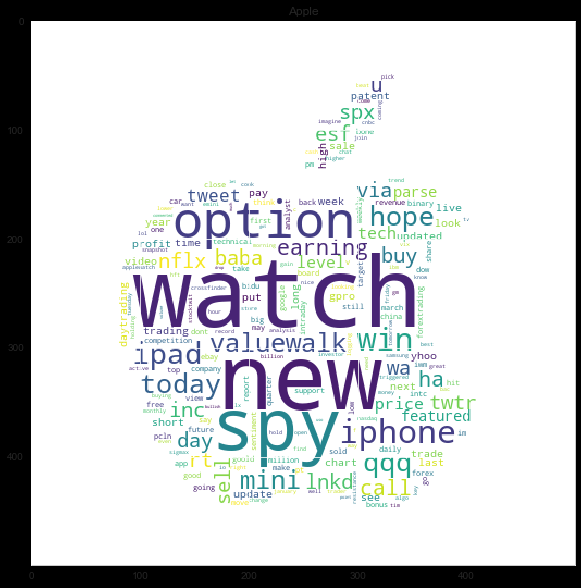

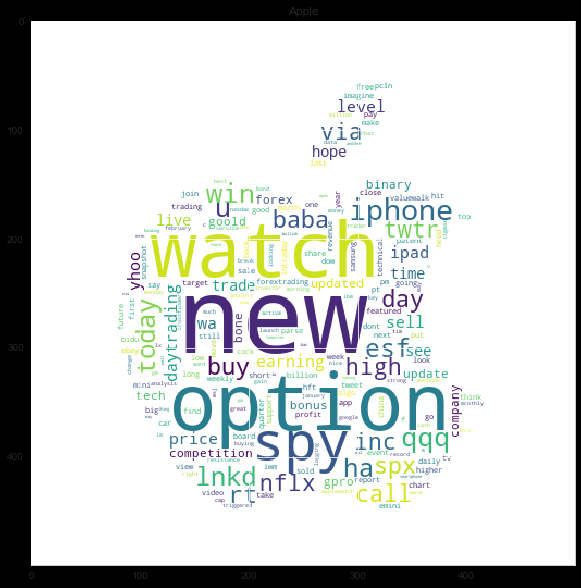

In [39]:
apple_mask = np.array(Image.open("img/apple.png"))
apple_mask = apple_mask[::3, ::3]
apple_image = apple_mask.copy()
apple_image[apple_image.sum(axis=2) == 0] = 255
wordcloud = WordCloud(collocations=False, mask = apple_image,background_color="white").generate(' '.join(aapl_df_positive.body.tolist()))
plt.figure( figsize=(20,10), facecolor='k')
plt.title("Apple")
plt.imshow(wordcloud)
apple_mask = np.array(Image.open("img/apple.png"))
apple_mask = apple_mask[::3, ::3]
apple_image = apple_mask.copy()
apple_image[apple_image.sum(axis=2) == 0] = 255
wordcloud = WordCloud(collocations=False, mask = apple_image,background_color="white").generate(' '.join(aapl_df_negative.body.tolist()))
plt.figure( figsize=(20,10), facecolor='k')
plt.title("Apple")
plt.imshow(wordcloud)

In [ ]:
# train_start_date=dev_start_date
# train_end_date=(dev_end_date-dev_start_date)*train_split_rate+train_start_date
# val_start_date=train_end_date
# test_end_date=dev_end_date

# print(train_start_date,train_end_date)

# train_set_list=split_dataset_into_window_chunck(train_start_date,train_end_date)
# val_set_list=split_dataset_into_window_chunck(val_start_date,test_end_date)

In [ ]:
news_rows_data=dev_data_dict["news_window"][['Top1','Label']]
news_rows_data['Top1'] = dev_data_dict["news_window"]['Top1'].str.cat(dev_data_dict["news_window"][[ 'Top2', 'Top3', 'Top4', 'Top5', 'Top6', 'Top7',
       'Top8', 'Top9', 'Top10', 'Top11', 'Top12', 'Top13', 'Top14', 'Top15',
       'Top16', 'Top17', 'Top18', 'Top19', 'Top20', 'Top21', 'Top22', 'Top23',
       'Top24', 'Top25']], sep=' ')
# news_together
news_rows_data.Top1 = deepTextCleanse(news_rows_data.Top1)
news_rows_data_list=news_rows_data.values.tolist()
print(len(news_rows_data_list[0]))


In [ ]:
all_word_freq_by_company_dict={}
all_word_label1_freq_by_company_dict={}


all_word_freq_1ct_by_company_dict={}
all_word_label1_freq_1ct_by_company_dict={}

tweets_by_company=dev_data_dict["tweets_window"].groupby('ticker_symbol')[['body','Label']].apply(lambda g: g.values.tolist()).to_dict()

for company in tweets_by_company:
    one_company_tweets=tweets_by_company[company]
    # for i, (index, row) in enumerate(dev_data_dict["tweets_window"].iterrows()):
    all_word_freq_dict, all_word_label1_freq_dict, all_word_freq_1ct_dict, all_word_label1_freq_1ct_dict={}, {}, {}, {}
    for i, line in enumerate(one_company_tweets):
        label=int(line[1])
        freq_dict=nltk.FreqDist(line[0].split(' '))       
        for key in freq_dict:
            if key in ['appl','aapl','msft','goog','googl','amzn','tsla','stock','market','fb','apple']:
                continue
            if key not in all_word_freq_dict:
                all_word_freq_dict[key]=0
                all_word_label1_freq_dict[key]=0
                all_word_freq_1ct_dict[key]=0
                all_word_label1_freq_1ct_dict[key]=0
      
            all_word_freq_dict[key]+=freq_dict[key]
            all_word_label1_freq_dict[key]+=freq_dict[key]*label
            
            all_word_freq_1ct_dict[key]+=1 if freq_dict[key]>0 else 0
            all_word_label1_freq_1ct_dict[key]+=1 if (freq_dict[key]*label >0) else 0
        if i>200000:
            break

    all_word_freq_by_company_dict[company]=all_word_freq_dict
    all_word_label1_freq_by_company_dict[company]=all_word_label1_freq_dict
    all_word_freq_1ct_by_company_dict[company]=all_word_freq_1ct_dict
    all_word_label1_freq_1ct_by_company_dict[company]=all_word_label1_freq_1ct_dict
            
        # Turnc before cleaning ???
        


all_word_freq_dict, all_word_label1_freq_dict, all_word_freq_1ct_dict, all_word_label1_freq_1ct_dict={}, {}, {}, {}
for i, line in enumerate(news_rows_data_list):
        label=int(line[1])
        freq_dict=nltk.FreqDist(line[0].split(' '))        
        for key in freq_dict:
            if key not in all_word_freq_dict:
                all_word_freq_dict[key]=0
                all_word_label1_freq_dict[key]=0
                all_word_freq_1ct_dict[key]=0
                all_word_label1_freq_1ct_dict[key]=0
      
            all_word_freq_dict[key]+=freq_dict[key]
            all_word_label1_freq_dict[key]+=freq_dict[key]*label
            
            all_word_freq_1ct_dict[key]+=1 if freq_dict[key]>0 else 0
            all_word_label1_freq_1ct_dict[key]+=1 if (freq_dict[key]*label >0) else 0

#         all_word_freq_by_company_dict[company]=all_word_freq_dict
#         all_word_label1_freq_by_company_dict[company]=all_word_label1_freq_dict
#         all_word_freq_1ct_by_company_dict[company]=all_word_freq_1ct_dict
#         all_word_label1_freq_1ct_by_company_dict[company]=all_word_label1_freq_1ct_dict

all_word_freq_by_company_dict["news"]=all_word_freq_dict
all_word_label1_freq_by_company_dict["news"]=all_word_label1_freq_dict
all_word_freq_1ct_by_company_dict["news"]=all_word_freq_1ct_dict
all_word_label1_freq_1ct_by_company_dict["news"]=all_word_label1_freq_1ct_dict
          

# for key in all_word_freq_dict:
#     print(f"{key}: {all_word_freq_dict[key]}")

# for key in all_word_label1_freq_dict:
#     print(f"{key}: {all_word_freq_dict[key]}")

# for key in all_word_freq_1ct_by_company_dict['AAPL']:
#     print(f"{key}: {all_word_freq_1ct_by_company_dict['AAPL'][key]}")

print(all_word_label1_freq_1ct_by_company_dict["news"])

In [ ]:
def sort_freq_dict(freq_dict):
    for col in freq_dict:
        freq_dict[col] = dict(sorted(freq_dict[col].items(), key = lambda x: x[1], reverse = True))

In [ ]:
def draw_bar_wordfreq(freq_dict):
    fig,ax = plt.subplots(4,2,figsize = (24,16))
    i = 0
    for col in freq_dict:
        j = i%2
    #     a = pd.DataFrame(list(all_word_label1_freq_1ct_by_company_dict[col].values())[:20],list(all_word_label1_freq_1ct_by_company_dict[col].keys())[:20])
        x = list(freq_dict[col].keys())[:10]
        y = list(freq_dict[col].values())[:10]
        ax[i//2][j].bar(x = x,height = y)
        ax[i//2][j].set_title(col)
        i+=1

In [ ]:
all_word_label1_freq_1ct_by_company_dict['TSLA']

In [ ]:
# contains the numbers of sentences every word appears where the label is 1
sort_freq_dict(all_word_label1_freq_1ct_by_company_dict)
draw_bar_wordfreq(all_word_label1_freq_1ct_by_company_dict)

In [ ]:
# contains the numbers of sentences every word appears
sort_freq_dict(all_word_freq_1ct_by_company_dict)
draw_bar_wordfreq(all_word_freq_1ct_by_company_dict)

In [ ]:
# contains the numbers of sentences every word appears, includes duplications in the same sentence
sort_freq_dict(all_word_freq_by_company_dict)
draw_bar_wordfreq(all_word_freq_by_company_dict)

In [ ]:
# contains the numbers of sentences every word appears where the label is 1, includes duplications in the same sentence
sort_freq_dict(all_word_label1_freq_by_company_dict)
draw_bar_wordfreq(all_word_label1_freq_by_company_dict)

In [ ]:
a = pd.DataFrame(list(all_word_label1_freq_1ct_by_company_dict[col].values())[:20],list(all_word_label1_freq_1ct_by_company_dict[col].keys())[:20])
a.plot.bar(x = a,y = a[0])